In [1106]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import json
from scipy.spatial import Delaunay
import skimage as ski
import einops

def read_img(img_name, img_dir = 'in_dir/', grayscale=False):
    if '.' not in img_name:
        img_name += '.jpg'
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    return img
images_out = 'images_out/' 
def save_img(fname, img_out, out_dir = images_out, grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

## Part 1

In [1107]:
in_dir = 'in_dir/'
img_me = read_img('me_resized.jpg', img_dir=in_dir)
img_george = read_img('george_small.jpg', img_dir=in_dir)

In [1109]:
corr_file = in_dir + 'points.json'
f = open(corr_file)
correspondences = json.load(f)
img1_points = np.array(correspondences['im1Points'])
img2_points = np.array(correspondences['im2Points'])
mean_points = (img1_points + img2_points)/2

In [1121]:
def plot_tri_on_img(img, points, fname='', out_dir = images_out, num_labels=False, plot_tri=True):
    tri = Delaunay(points).simplices
    x, y = points[:, 0], points[:,1]
    if num_labels:
        [plt.text(x[i], y[i], f'{i}', fontsize=7, ha='right', color='green') for i in range(len(x))]
    if plot_tri:
        plt.triplot(x, y, tri)
    plt.plot(x, y, 'o', markersize=3)
    plt.imshow(img)
    plt.axis('off')
    if fname != '':
        plt.savefig(out_dir + fname, bbox_inches='tight')
    
    plt.show()

def get_tri(weighted_pts):
    return Delaunay(weighted_pts)

def weighted_sum(arr1, arr2, weight):
    return arr1 * weight + arr2 * (1-weight)

def get_weighted_tri(img1_pts, img2_pts, warp_frac):
    weighted_pts = weighted_sum(img1_pts, img2_pts, warp_frac)
    return get_tri(weighted_pts)

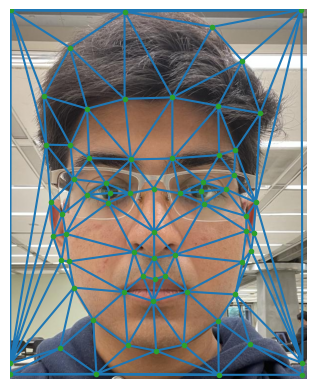

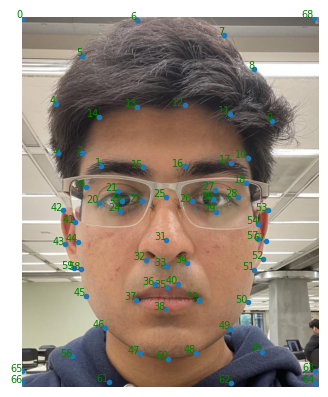

In [1125]:
part_1_out = images_out + 'part_1/'
plot_tri_on_img(
    img_me, img1_points,
    fname='me_triangulation.jpg',
    out_dir=part_1_out
)
plot_tri_on_img(
    img_me,
    img1_points,
    fname='me_points.jpg',
    out_dir=part_1_out,
    plot_tri=False,
    num_labels=True
)

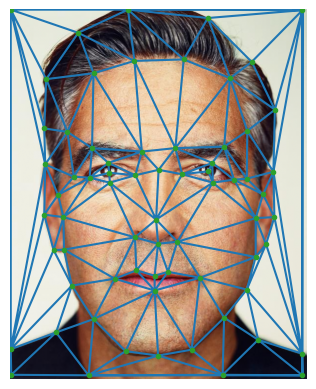

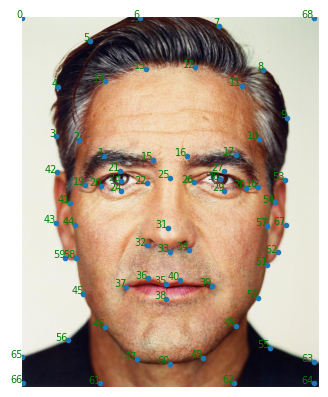

In [1126]:
plot_tri_on_img(
    img_george,
    img2_points,
    fname='george_triangulation.jpg',
    out_dir=part_1_out
)
plot_tri_on_img(
    img_george,
    img2_points,
    fname='george_points.jpg',
    out_dir=part_1_out,
    plot_tri=False,
    num_labels=True
)

## Part 2

In [1127]:
def compute_transform(points):
    a, b, c = points
    trans = np.eye(3)
    trans[:2,0] = c - a
    trans[:2,1] = b - a
    trans[:2,2] = a
    # print(points, trans)
    return trans

def compute_warp_src_dst(src_points, dst_points, tris):
    num_tri = len(tris)
    transforms = np.zeros((num_tri, 3, 3))
    for (i, tri) in enumerate(tris):
        tri_idx = tris[i]
        dst_tri_points = list(map(lambda x: dst_points[x], tri_idx))
        src_tri_points = list(map(lambda x: src_points[x], tri_idx))
        
        g_1 = compute_transform(src_tri_points)
        g_1_inv = np.linalg.inv(g_1)
        g_2 = compute_transform(dst_tri_points)
        transforms[i] = g_2 @ g_1_inv
    return transforms

mean_tri = get_weighted_tri(img1_points, img2_points, 0.5)
mean_to_img1 = compute_warp_src_dst(mean_points, img1_points, mean_tri.simplices)

In [1128]:
def plot_tri(img, weighted_pts, tri):
    tri_points = np.array(list(map(lambda x: weighted_pts[x], tri)))
    cc, rr = ski.draw.polygon(tri_points[:,0], tri_points[:,1], shape=None)
    blank = np.zeros((img.shape))
    blank[rr, cc] = img_me[rr, cc]
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.imshow(blank, cmap='gray')

In [1129]:
def get_inv_mapped_color(img, mean_tri, mean_to_img_transforms, weighted_shape_pts):
    # Flatten img to use for interpolation
    X, Y = np.mgrid[:img.shape[0], :img.shape[1]]
    points = np.dstack((X.ravel(), Y.ravel())).squeeze()
    flat_img = einops.rearrange(img, ('h w c -> (h w) c'))
    new_image = np.zeros_like(img)
    color_interp = scipy.interpolate.NearestNDInterpolator(points, flat_img)

    for (i, tri) in enumerate(mean_tri.simplices):
        # Gets all points within mean triangle
        tri_points = np.array(list(map(lambda x: weighted_shape_pts[x], tri)))
        cc, rr = ski.draw.polygon(tri_points[:,0], tri_points[:,1], shape=None)
        
        src_tri_coords = np.array([cc, rr, np.ones_like(rr)])   # Create homogeneous coordinates
        new =  mean_to_img_transforms[i] @ src_tri_coords     # Apply transformation to get tri in original image
        c_n, r_n = new[0], new[1]
        rr = np.clip(rr, 0, img.shape[0]-1)
        cc = np.clip(cc, 0, img.shape[1]-1)
        # Interpolate at to get the colors of the points when inv mapped
        tri_interp = color_interp((r_n, c_n))
        new_image[rr, cc] = tri_interp
    return new_image

# Morphs a single image to the given shape
def morph_to_target_shape(img, img_points, target_shape, triangulation):
    transforms_to_img = compute_warp_src_dst(target_shape, img_points, triangulation.simplices)
    colors_from_img = get_inv_mapped_color(img, triangulation, transforms_to_img, target_shape) 
    return colors_from_img

# Computes the morphed img, weighting img1 by warp_frac and img2 by (1-warp_frac)
def compute_morphed_img(img1, img2, triangulation, img1_points, img2_points, warp_frac, dissolve_frac=None):
    if dissolve_frac == None: dissolve_frac = warp_frac
    weighted_shape_pts = weighted_sum(img1_points, img2_points, warp_frac)

    colors_from_img1 = morph_to_target_shape(img1, img1_points, weighted_shape_pts, triangulation)
    colors_from_img2 = morph_to_target_shape(img2, img2_points, weighted_shape_pts, triangulation) 
    
    return weighted_sum(colors_from_img1, colors_from_img2, dissolve_frac)

def compute_morph_seq(img1, img2, img1_points, img2_points, num_img):
    img_seq = []
    mean_tri = get_weighted_tri(img1_points, img2_points, 0.5)
    for t in range(0,num_img):
        warp_frac = t/num_img
        img_seq.append(
            compute_morphed_img(img1, img2, mean_tri, img1_points, img2_points, warp_frac, dissolve_frac=None)
        )
    return img_seq

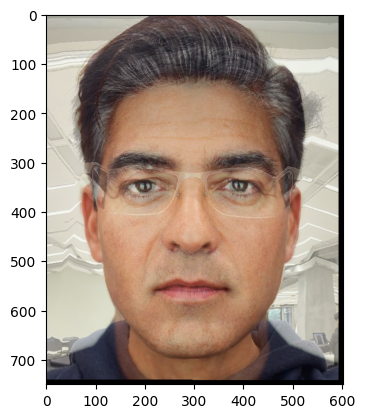

In [1131]:
warp_frac = 0.5
mid_way = compute_morphed_img(
    img_me, img_george, 
    get_weighted_tri(img1_points, img2_points, 0.5),
    img1_points, img2_points, 
    warp_frac, 
    dissolve_frac=None
)
save_img('mid_way_face', mid_way, out_dir=images_out + 'part_2')
plt.imshow(mid_way)

## Part 3

In [795]:
seq = compute_morph_seq(img_me, img_george, img1_points, img2_points, 45)

In [802]:
out_dir=images_out+'part_3/seq_img/'
for i, img in enumerate(seq):
    save_img('img_' + str(i), img, out_dir=out_dir)

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_23384/1578824714.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(out_dir + filename))


In [811]:
### Create GIF
im1 = Image.open(out_dir + 'img_0.jpg')
extra_images = []
for i in range(1, 45):
    img_name = out_dir + 'img_' + str(i) + '.jpg'
    extra_images.append(Image.open(img_name))
for i in range(44, 0, -1):
    img_name = out_dir + 'img_' + str(i) + '.jpg'
    extra_images.append(Image.open(img_name))
im1.save(out_dir + "out.gif", save_all=True, append_images=extra_images, duration=40, loop=0)

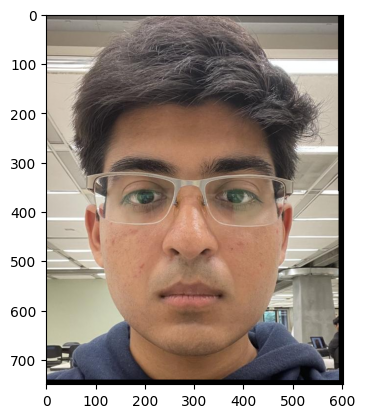

In [1139]:
morph1 = compute_morphed_img(
    img_me, img_george, 
    mean_tri,
    img1_points, img2_points,
    warp_frac=1.00, 
    dissolve_frac=1
)
plt.imshow(morph1)

## Part 4

In [1144]:
in_dir = 'in_dir/imm_face_db/'
img_name = '01-1m'
img = read_img(img_name = img_name, img_dir = in_dir)

In [1145]:
f = open(in_dir + img_name+'.asf')
lines = [line.rstrip().split('\t') for line in f][16:-5]
# Corners and border midpoints
extra_points = [[0,0],
                [img.shape[1]/2 + 0.5, 0],
                [img.shape[1] - 1, 0 + 0.4], 
                [img.shape[1] - 0.7, img.shape[0]/2 + 0.9],
                [img.shape[1] - 0.3, img.shape[0 ]],
                [img.shape[1]/2 + 0.1, img.shape[0]], 
                [0 + 0.1, img.shape[0]],
                [0 + 0.3, img.shape[0]/2]]

In [1146]:
point_dict = {}
for fname in os.listdir(in_dir):
    if '.asf' not in fname:
        continue
    name = fname.split('.')[0]
    f = open(in_dir + fname)
    lines = [line.rstrip().split('\t') for line in f][16:-5]
    point_dict[name] = np.zeros((len(lines)+8, 2))
    for (i, line) in enumerate(lines):
        point_dict[name][i, :] = [float(line[2])*img.shape[1], float(line[3])*img.shape[0]]
    point_dict[name][-8:] = extra_points
point_dict = dict(sorted(point_dict.items()))
print(len(point_dict), len(point_dict['01-1m']))
avg_shape = np.mean(list(point_dict.values()), axis=0)

240 66


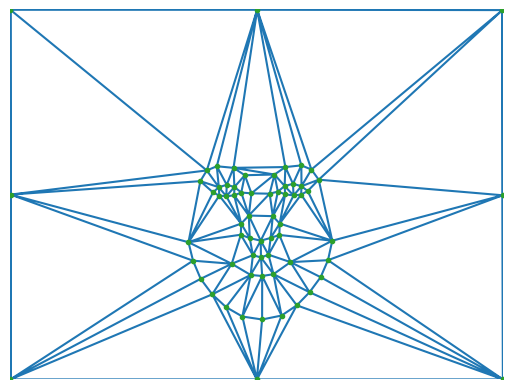

In [1222]:
plot_tri_on_img(
    np.ones_like(img),
    avg_shape,
    fname='avg_dane_shape.jpg',
    out_dir=images_out + 'part_4/',
)

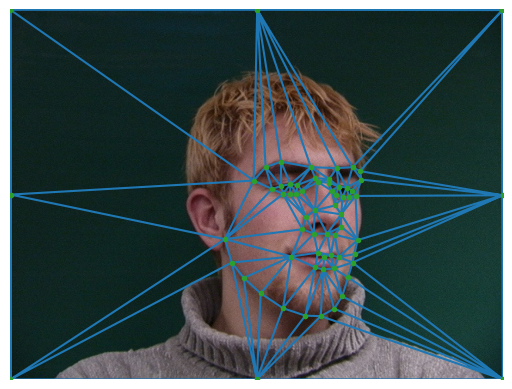

In [1237]:
img_name = '01-4m'
img = read_img(img_name = img_name, img_dir = in_dir)
plot_tri_on_img(
    img,
    point_dict[img_name]
)

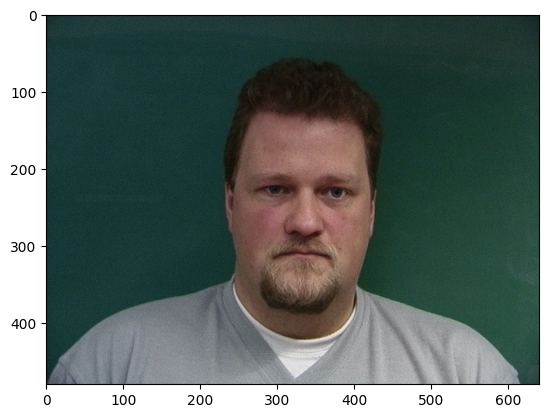

In [1092]:
in_dir = 'in_dir/imm_face_db/'
img_name = '05-1m'
img = read_img(img_name = img_name, img_dir = in_dir)
plt.imshow(img)

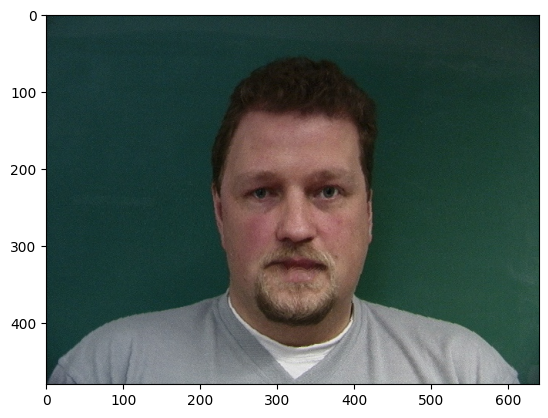

In [1093]:
morph = morph_to_target_shape(
    img, 
    point_dict[img_name], 
    avg_shape, 
    get_tri(avg_shape)
)
plt.imshow(morph)

In [1233]:
def morph_dane_image_to_avg(img_name, in_dir=in_dir, out_dir=None, save=False, show=False):
    img = read_img(img_name = img_name, img_dir=in_dir)
    morph = morph_to_target_shape(
        img, 
        point_dict[img_name], 
        avg_shape, 
        get_tri(avg_shape)
    )
    
    if save:
        save_img(img_name, img, out_dir=out_dir)
        save_img(img_name+'_morphed', morph, out_dir=out_dir)
    if show:
        plt.axis('off')
        plt.imshow(morph)
    return morph
    
def compute_avg_dane_face(in_dir, filter='', out_dir=None, save=False, show=False):
    avg_face = np.zeros_like(img)
    num_faces = 0
    for fname in os.listdir(in_dir):
        if '.jpg' not in fname or filter not in fname:
            continue
        name = fname.split('.')[0]
        avg_face += morph_dane_image_to_avg(name)
        num_faces += 1
        # if num_faces > 10: break
    avg_face = avg_face / num_faces

    if save:
        file_name = 'avg_face'
        if filter: file_name += '_' + filter
        save_img(file_name, avg_face, out_dir=out_dir)
    if show:
        plt.axis('off')
        plt.imshow(avg_face)
    return avg_face

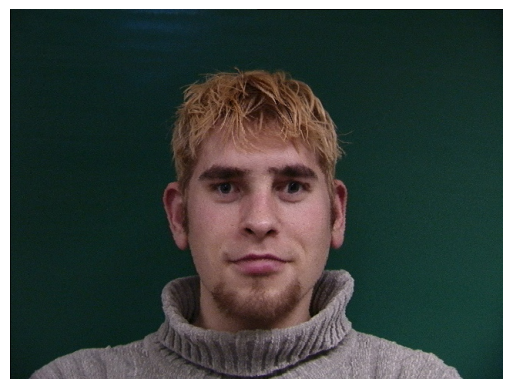

In [1239]:
morph = morph_dane_image_to_avg('01-1m', out_dir=images_out+'part_4', save=True, show=True)

In [1225]:
morph = morph_dane_image_to_avg('09-1m', out_dir=images_out+'part_4', save=True)

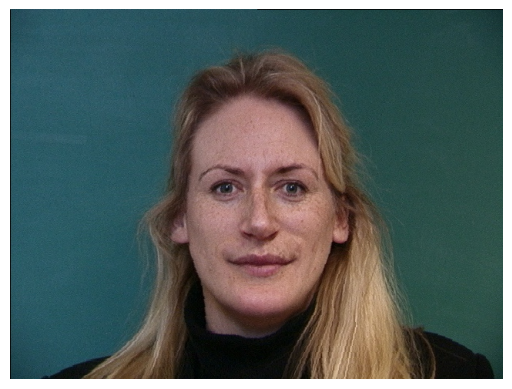

In [1226]:
morph = morph_dane_image_to_avg('35-1f', out_dir=images_out+'part_4', save=True, show=True)

In [1227]:
morph = morph_dane_image_to_avg('15-1f', out_dir=images_out+'part_4', save=True)

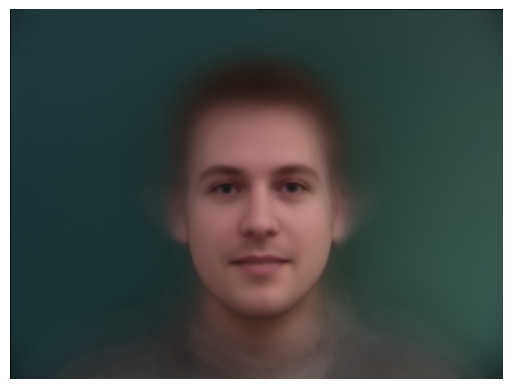

In [1234]:
in_dir = 'in_dir/imm_face_db/'
avg_face = compute_avg_dane_face(in_dir, out_dir=images_out+'part_4', save=True, show=True)

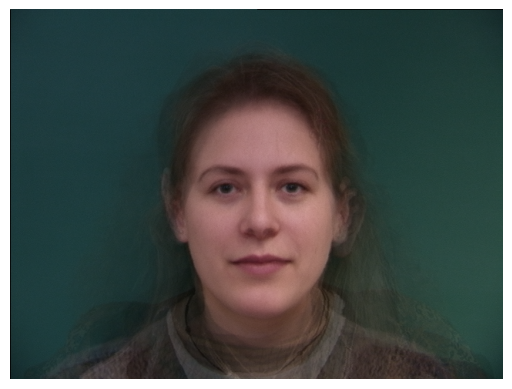

In [1240]:
in_dir = 'in_dir/imm_face_db/'
avg_face = compute_avg_dane_face(in_dir, filter='f', out_dir=images_out+'part_4', save=True, show=True)

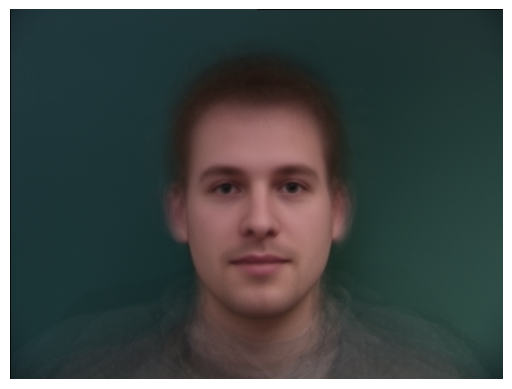

In [1241]:
in_dir = 'in_dir/imm_face_db/'
avg_face = compute_avg_dane_face(in_dir, filter='1m', out_dir=images_out+'part_4', save=True, show=True)